# Intro

## Load and import CapsNet

First, let's clone our GitHub repo and import all parts which will be used in this notebook.

In [1]:
!pip install --no-cache-dir --upgrade git+https://github.com/tumido/face_biometrics_descriptor-code.git

from sklearn.datasets import fetch_lfw_people
from capsnet import preprocess_lfw_people, CapsNet

  Cloning https://github.com/tumido/face_biometrics_descriptor-code.git to /tmp/pip-req-build-ipyep2_h
  Found existing installation: capsnet 0.3.0
    Uninstalling capsnet-0.3.0:
      Successfully uninstalled capsnet-0.3.0
  Running setup.py install for capsnet ... done


Using TensorFlow backend.


## Auxilary imports

Additional imports used in this Notebook would help to visualize data.

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

Install and start a TensorBoard in Colab

In [3]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc = TensorBoardColab()
tensor_board_callback = TensorBoardColabCallback(tbc, batch_size=10, histogram_freq=5, write_graph=True, write_grads=True, write_images=True)

Wait for 8 seconds...
TensorBoard link:
http://14b9726e.ngrok.io


## Verify GPU

in the next cell we verify that a GPU is available to our use. The output should contain a GPU details.

In [4]:
from tensorflow.test import is_gpu_available
from tensorflow.python.client import device_lib

if not is_gpu_available():
    raise SystemError('GPU device not found')

desc = [f'path: {d.name}, {d.physical_device_desc}' for d in device_lib.list_local_devices() if d.device_type == "GPU"][0]
print("\n".join(desc.split(", ")))

path: /device:GPU:0
device: 0
name: Tesla T4
pci bus id: 0000:00:04.0
compute capability: 7.5


## Collect data set 

We're gonna be working with LFW dataset

In [0]:
people = fetch_lfw_people(
    color=True,
    min_faces_per_person=25
)


data = preprocess_lfw_people(people)
(x_train, y_train), (x_test, y_test) = data

In [6]:
metrics = {
    "Identities": len(np.unique(people.target, axis=0)),
    "Total images": people.target.shape[0],
    "Train images": len(y_train),
    "Test images": len(y_test),
    "Image shape": x_train.shape[1:]
}
pd.DataFrame.from_dict(metrics, columns=["Value"], orient='index')

,Value
Identities,42
Total images,2588
Train images,2070
Test images,518
Image shape,"(32, 32, 3)"


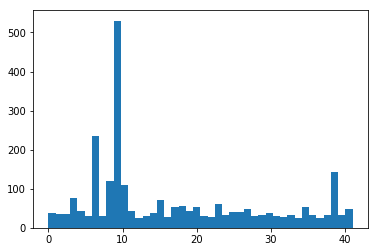

In [7]:
_ = plt.hist(people.target, bins=people.target_names.shape[0])

18: Jean Chretien


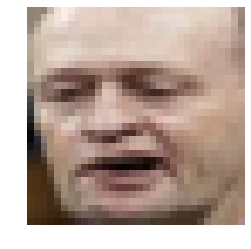

In [8]:
i = randint(0, len(x_train))
plt.imshow(x_train[i])
plt.axis('off') 
print("{}: {}".format(np.argmax(y_train[i]), people.target_names[np.argmax(y_train[i])]))

## CapsNet

Let's begin training our network

In [9]:
model = CapsNet(
    x_train.shape[1:],
    len(np.unique(y_train, axis=0))
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv2d (Conv2D)         (None, 24, 24, 256)  62464       input_image[0][0]                
__________________________________________________________________________________________________
encoder_dropout (Dropout)       (None, 24, 24, 256)  0           encoder_conv2d[0][0]             
__________________________________________________________________________________________________
encoder_feature_caps_

In [10]:
history = model.train(data, batch_size=10, extra_callbacks=[tensor_board_callback])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/200
207/207 [==============================] - 111s 537ms/step - loss: 0.7594 - capsnet_loss: 0.7593 - decoder_loss: 0.1788 - capsnet_acc: 0.1473 - val_loss: 0.7746 - val_capsnet_loss: 0.7746 - val_decoder_loss: 0.0406 - val_capsnet_acc: 0.1969

Epoch 00001: val_capsnet_acc improved from -inf to 0.19691, saving model to model/weights.01.h5
Epoch 2/200
207/207 [==============================] - 107s 517ms/step - loss: 0.7661 - capsnet_loss: 0.7661 - decoder_loss: 0.0370 - capsnet_acc: 0.1657 - val_loss: 0.7615 - val_capsnet_loss: 0.7615 - val_decoder_loss: 0.0333 - val_capsnet_acc: 0.1969

Epoch 00002: val_capsnet_acc did not improve from 0.19691
Epoch 3/200
207/207 [==============================] - 106s 514ms/step - loss: 0.7444 - capsnet_loss: 0.7444 - decoder_loss: 0.0339 - capsnet_acc: 0.1831 - val_loss: 0.7484 - val_capsnet_loss: 0.7483 - val_decode

## Results of training

Let's see how our accuracy evolved during training.

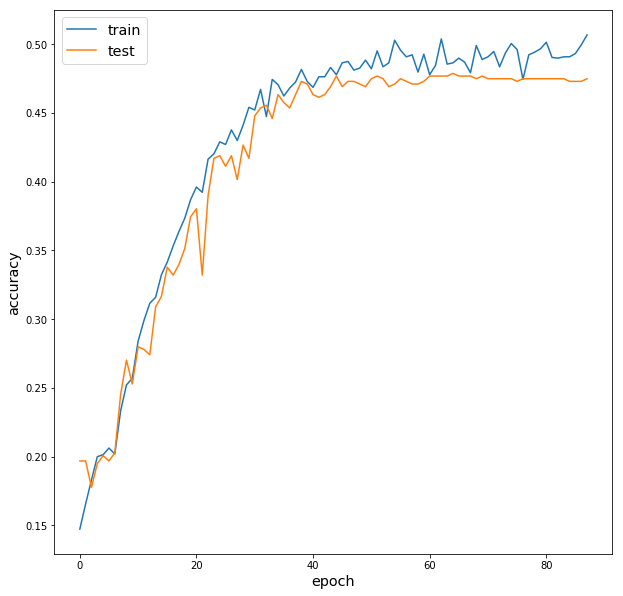

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['capsnet_acc'])
plt.plot(history.history['val_capsnet_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

## Save trained model

Let's save our trained model into your [Google Drive](https://drive.google.com/drive/my-drive) first. The following cell will request permissions to access your Drive and then save the model as `model.h5`.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

model.save_weights('/content/gdrive/My Drive/model.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Saving model's weights to "/content/gdrive/My Drive/model.h5"... Done


## Testing

In [13]:
metrics = model.test(x_test, y_test, )
pd.DataFrame.from_dict(metrics, columns=["Value"], orient='index')

518/518 [==============================] - 7s 13ms/step


,Value
loss,0.382421
acc,0.474903


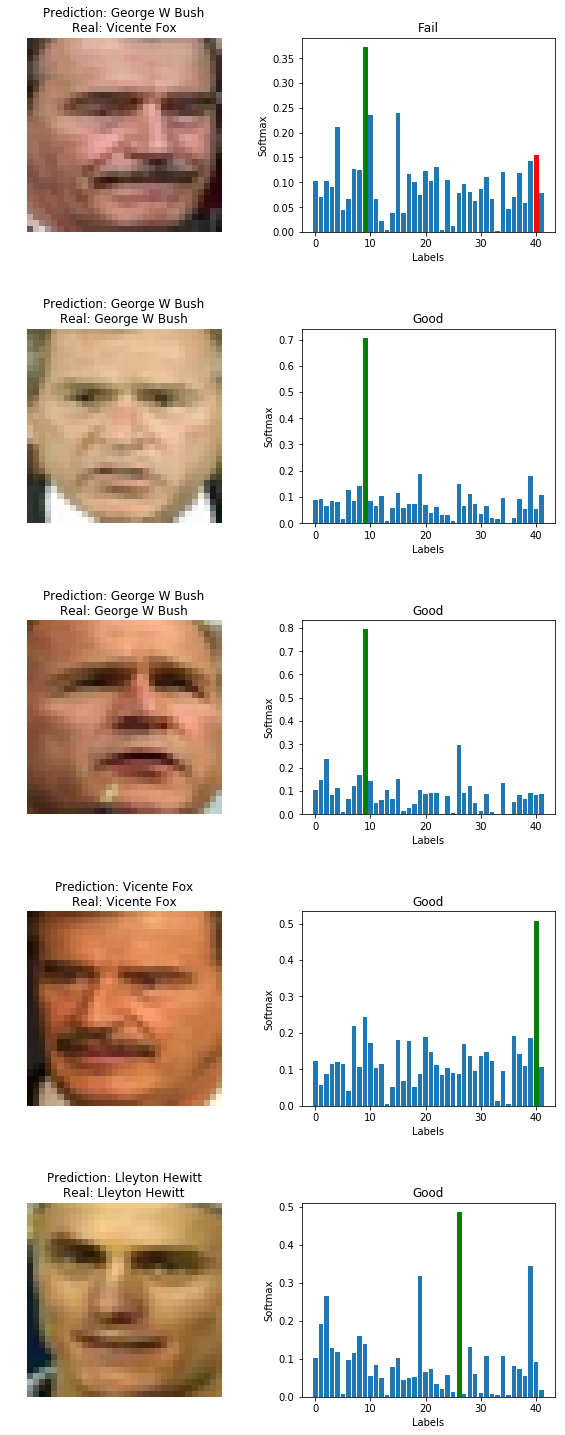

In [14]:
predictions = model.predict(x_test)

fig, axs = plt.subplots(5, 2, figsize=(10, 25))
fig.subplots_adjust(hspace=.5)
axs = axs.ravel()
bins = len(np.unique(y_train, axis=0))
for i in range(10):
    predicted_idx = np.argmax(predictions[i // 2])
    real_idx = np.argmax(y_test[i // 2])
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(x_test[i // 2])
        predicted_name = people.target_names[predicted_idx]
        real_name = people.target_names[real_idx]
        axs[i].set_title("Prediction: %s\nReal: %s" % (predicted_name, real_name))
    else:
        bars = axs[i].bar(np.arange(bins), predictions[i // 2])
        axs[i].set_ylabel("Softmax")
        axs[i].set_xlabel("Labels")
        bars[real_idx].set_color('r')
        bars[predicted_idx].set_color('g')
        axs[i].set_title("Good" if real_idx == predicted_idx else 'Fail')

plt.show()